## Analyzing Sentiment Data with Finbert

**Load Model**

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import feedparser
import requests


MODEL_NAME = "ProsusAI/finbert" #tabularisai/ModernFinBERT" or "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.eval()

id2label = model.config.id2label  # e.g. {0: 'negative', 1: 'neutral', 2: 'positive'}

print(f"{MODEL_NAME} loaded")

c:\Users\skurono\Desktop\SCMC\scmc-2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ProsusAI/finbert loaded


**Sanity Inference Check**

In [2]:
pipe = pipeline("text-classification", model=MODEL_NAME)

#inference check (positive)
print(pipe('Stocks rallied and the British pound gained'))

Device set to use cpu


[{'label': 'positive', 'score': 0.6949422359466553}]


**Scoring Function**

In [3]:
def finbert_score(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).numpy()
    labels = [id2label[int(i)] for i in probs.argmax(axis=1)]
    return labels, probs


**Load Data**

In [10]:
import pandas as pd
from pathlib import Path

CANONICAL_FIELDS = [
    'id', 'report_id', 'ticker', 'company', 'date', 'source', 'doc_type', 'item', 'section_type', 'section_heading', 'chunk_index', 'page_start', 'page_end', 'text', 'source_file'
]

base = Path('processed_data/final')
data_paths = [
    base / 'pdf_sections_chunks.csv',
    base / 'atz_mda_chunks.csv',
    base / 'sec_filings_extracted_10q.csv',
    base / 'sec_filings_extracted_8k.csv',
    base / 'press_releases_chunks.csv',
    base / 'financial_news_dataset.csv',
    base / 'news_data_final.csv',
]

frames = []
for p in data_paths:
    if not p.exists():
        print(f'[warn] missing {p}')
        continue
    df = pd.read_csv(p)
    for col in CANONICAL_FIELDS:
        if col not in df.columns:
            df[col] = ''
    df = df.reindex(columns=CANONICAL_FIELDS)
    frames.append(df)
    print(f'[info] loaded {p.name}: {len(df)} rows')

if frames:
    master = pd.concat(frames, ignore_index=True)
    master = master[master['text'].astype(str).str.len() > 0]
    master = master.drop_duplicates(subset=['text', 'source_file', 'section_heading'])
else:
    master = pd.DataFrame(columns=CANONICAL_FIELDS)

out_path = base / 'master_corpus.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
master.to_csv(out_path, index=False)
print(f'[done] master rows={len(master)} -> {out_path}')
print(master.head())


[info] loaded pdf_sections_chunks.csv: 3178 rows
[info] loaded atz_mda_chunks.csv: 279 rows
[info] loaded sec_filings_extracted_10q.csv: 1979 rows
[info] loaded sec_filings_extracted_8k.csv: 146 rows
[info] loaded press_releases_chunks.csv: 189 rows
[info] loaded financial_news_dataset.csv: 30 rows
[info] loaded news_data_final.csv: 155 rows
[done] master rows=5799 -> processed_data\final\master_corpus.csv
                                                  id  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...   
1  20231103_Digital_Sales_Poised_to_Double_by_202...   
2  20231103_Digital_Sales_Poised_to_Double_by_202...   
3  20231103_Digital_Sales_Poised_to_Double_by_202...   
4  20231103_Digital_Sales_Poised_to_Double_by_202...   

                                           report_id ticker company date  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
1  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
2  20231103_Digital_Sales

**Use master DF**

In [ ]:
print(master.head())

#run finbert



                                                  id  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...   
1  20231103_Digital_Sales_Poised_to_Double_by_202...   
2  20231103_Digital_Sales_Poised_to_Double_by_202...   
3  20231103_Digital_Sales_Poised_to_Double_by_202...   
4  20231103_Digital_Sales_Poised_to_Double_by_202...   

                                           report_id ticker company date  \
0  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
1  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
2  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
3  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   
4  20231103_Digital_Sales_Poised_to_Double_by_202...    ATZ     NaN  NaN   

      source       doc_type item section_type  \
0  bloomberg  research_note  NaN       thesis   
1  bloomberg  research_note  NaN       growth   
2  bloomberg  research_note  NaN       growth   
3  bloombe

**Run Model**

In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Paths
MASTER_PATH = "nlp/processed_data/final/master_corpus.csv"
OUTPUT_PATH = "nlp/processed_data/final/master_corpus_finbert.csv"

# Load data
df = master
print(df.shape)

# FinBERT model
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def score_batch(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc).logits
        probs = out.softmax(dim=-1).cpu().numpy()
    return probs  # columns: [neg, neu, pos]

# Run in batches
batch_size = 16
neg_list, neu_list, pos_list = [], [], []
for i in range(0, len(df), batch_size):
    batch = df["text"].iloc[i:i+batch_size].fillna("").tolist()
    probs = score_batch(batch)
    neg_list.extend(probs[:, 0])
    neu_list.extend(probs[:, 1])
    pos_list.extend(probs[:, 2])
    if i % 100 == 0:
        print(f"scored {i} / {len(df)}")

df["finbert_neg"] = neg_list
df["finbert_neu"] = neu_list
df["finbert_pos"] = pos_list
df["finbert_score"] = df["finbert_pos"] - df["finbert_neg"]  # simple sentiment score

df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved {len(df)} rows -> {OUTPUT_PATH}")
df.head()


(5799, 15)
scored 0 / 5799
scored 400 / 5799
scored 800 / 5799
scored 1200 / 5799
scored 1600 / 5799
scored 2000 / 5799
scored 2400 / 5799
scored 2800 / 5799
scored 3200 / 5799
scored 3600 / 5799
scored 4000 / 5799
scored 4400 / 5799
scored 4800 / 5799
scored 5200 / 5799
scored 5600 / 5799
Saved 5799 rows -> nlp/processed_data/final/master_corpus_finbert.csv


,id,report_id,ticker,company,date,source,doc_type,item,section_type,section_heading,chunk_index,page_start,page_end,text,source_file,finbert_neg,finbert_neu,finbert_pos,finbert_score
0,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,thesis,"Aritzia Sales Could Double on US Expansion, Gr...",0,1,1,( bloomberg intelligence ) - - aritzia has a l...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.889320,0.008364,0.102316,-0.787004
1,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,1. Setting Up Significant White Space Potential,1,1,1,aritzia's plan to lift revenue 60 % to c $ 3. ...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.842159,0.007463,0.150377,-0.691782
2,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,"Private Brands Are 95% of Sales: Wilfred 28%, ...",2,1,1,"26 %, super puff 7 - 8 %, denim forum, sunday ...",nlp\raw_data\bloomberg\atz_research\20231103_D...,0.048370,0.018046,0.933584,0.885214
3,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,2. Margin Can Increase at Least 500 Bps in 2024,3,1,2,aritzia's ebitda margin could expand by 500 bp...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.114497,0.166290,0.719213,0.604716
4,20231103_Digital_Sales_Poised_to_Double_by_202...,20231103_Digital_Sales_Poised_to_Double_by_202...,ATZ,NaN,NaN,bloomberg,research_note,NaN,growth,3. Digital Sales Poised to Double by 2027 (Cor...,4,2,2,aritzia's c $ 800 million of digital sales cou...,nlp\raw_data\bloomberg\atz_research\20231103_D...,0.562942,0.010367,0.426692,-0.136250


**Final Scores**

In [18]:
import numpy as np
import pandas as pd

# --- 1. Robust / versatile scoring + labeling helpers ---

def compute_finbert_score(row, method="pos_minus_neg", neutral_band=0.05):
    """
    Compute a scalar sentiment score from FinBERT probs.

    method:
      - "pos_minus_neg": score = pos - neg   (range roughly [-1, 1])
      - "expectation":   score = -1*neg + 0*neu + 1*pos
      - "signed_conf":   score = (pos - neg) * (1 - neu)
    """
    neg = row["finbert_neg"]
    neu = row["finbert_neu"]
    pos = row["finbert_pos"]

    if method == "pos_minus_neg":
        score = pos - neg
    elif method == "expectation":
        score = -1 * neg + 0 * neu + 1 * pos
    elif method == "signed_conf":
        score = (pos - neg) * (1 - neu)
    else:
        raise ValueError(f"Unknown method: {method}")

    return score


def add_finbert_labels(df, score_col="finbert_score", neutral_band=0.05):
    """
    Add a categorical sentiment label based on a score column.
    Labels: 'negative', 'neutral', 'positive'.
    """
    df = df.copy()
    scores = df[score_col]

    conditions = [
        scores > neutral_band,
        scores < -neutral_band,
    ]
    choices = ["positive", "negative"]
    df["finbert_label"] = np.select(conditions, choices, default="neutral")
    return df


def summarize_sentiment(
    df,
    score_col="finbert_score",
    label_col="finbert_label",
    groupby_cols=None,
):
    """
    Compute summary metrics for FinBERT sentiment scores.

    If groupby_cols is None -> global summary (single-row DataFrame).
    Otherwise -> grouped summary by specified columns.
    """

    def agg_block(x: pd.Series) -> pd.Series:
        x = x.dropna()
        if x.empty:
            return pd.Series(
                {
                    "n": 0,
                    "mean": np.nan,
                    "std": np.nan,
                    "median": np.nan,
                    "min": np.nan,
                    "max": np.nan,
                    "p10": np.nan,
                    "p25": np.nan,
                    "p75": np.nan,
                    "p90": np.nan,
                }
            )

        return pd.Series(
            {
                "n": x.size,
                "mean": x.mean(),
                "std": x.std(),
                "median": x.median(),
                "min": x.min(),
                "max": x.max(),
                "p10": x.quantile(0.10),
                "p25": x.quantile(0.25),
                "p75": x.quantile(0.75),
                "p90": x.quantile(0.90),
            }
        )

    # --- Global summary (no grouping) ---
    if groupby_cols is None:
        x = df[score_col]
        summary = agg_block(x).to_frame().T  # single-row DataFrame

        # Add label shares as extra columns if labels exist
        if (label_col is not None) and (label_col in df.columns):
            label_counts = df[label_col].value_counts(normalize=True)
            for lab, val in label_counts.items():
                summary[f"share_{lab}"] = val

        return summary

    # --- Grouped summary ---
        # --- Grouped summary ---
    g = df.groupby(groupby_cols, dropna=False)

    # always return a DataFrame (even if only 1 group)
    score_summary = (
        g[score_col]
        .apply(agg_block)
        .unstack()             # rows = groups, cols = metrics
        .rename_axis(index=groupby_cols)
    )

    if (label_col is not None) and (label_col in df.columns):
        label_counts = (
            g[label_col]
            .value_counts(normalize=True)
            .unstack(fill_value=0)
        )
        label_counts.columns = [f"share_{c}" for c in label_counts.columns]

        # ensure DataFrame before join
        label_counts = label_counts.to_frame() if isinstance(label_counts, pd.Series) else label_counts

        summary = score_summary.join(label_counts, how="left")
    else:
        summary = score_summary

    return summary


# --- 2. Apply helpers to your current df ---

# Optionally recompute score with chosen method
df["finbert_score"] = df.apply(
    compute_finbert_score,
    axis=1,
    method="pos_minus_neg",  # or "expectation", "signed_conf"
)

# Add labels
df = add_finbert_labels(df, score_col="finbert_score", neutral_band=0.05)

# Global metrics
global_summary = summarize_sentiment(df)
print("Global sentiment summary:")
display(global_summary)

# Example: per-ticker summary
ticker_summary = summarize_sentiment(df, groupby_cols=["ticker"])
print("Per-ticker sentiment summary (head):")
display(ticker_summary.head())

# Example: per-source summary
source_summary = summarize_sentiment(df, groupby_cols=["source"])
print("Per-source sentiment summary:")
display(source_summary)


Global sentiment summary:


,n,mean,std,median,min,max,p10,p25,p75,p90,share_positive,share_negative,share_neutral
0,5799.0,0.275103,0.665132,0.54528,-0.943458,0.935705,-0.892052,-0.126715,0.889332,0.919556,0.612864,0.268495,0.118641


Per-ticker sentiment summary (head):


,n,mean,std,median,min,max,p10,p25,p75,p90,share_negative,share_neutral,share_positive
ticker,,,,,,,,,,,,,
ATZ,1489.0,0.083923,0.775004,0.323708,-0.943458,0.935705,-0.929043,-0.887943,0.871791,0.914497,0.426461,0.038281,0.535259
ATZ.TO,10.0,0.034570,0.539680,0.065711,-0.898200,0.845968,-0.672321,-0.120327,0.161596,0.788908,0.300000,0.200000,0.500000
LULU,1002.0,0.468763,0.607276,0.834944,-0.936550,0.934737,-0.728249,0.012629,0.908013,0.926408,0.186627,0.082834,0.730539
NKE,1173.0,0.393124,0.622938,0.756751,-0.939581,0.933599,-0.722793,-0.018844,0.903391,0.923732,0.225916,0.106564,0.667519
TXT,2125.0,0.253731,0.588191,0.134871,-0.942394,0.932747,-0.771787,-0.011400,0.860336,0.913528,0.219765,0.198118,0.582118


Per-source sentiment summary:


,n,mean,std,median,min,max,p10,p25,p75,p90,share_negative,share_neutral,share_positive
source,,,,,,,,,,,,,
bloomberg,3176.0,0.268601,0.714212,0.668986,-0.939581,0.935401,-0.920121,-0.340635,0.897459,0.923193,0.309509,0.078715,0.611776
mda_canada,279.0,0.382462,0.629497,0.727785,-0.939076,0.932492,-0.724608,-0.012519,0.889133,0.908282,0.240143,0.028674,0.731183
press_release,189.0,0.510200,0.623040,0.835617,-0.943458,0.935705,-0.843040,0.328839,0.889959,0.919425,0.158730,0.005291,0.835979
sec,2125.0,0.253731,0.588191,0.134871,-0.942394,0.932747,-0.771787,-0.011400,0.860336,0.913528,0.219765,0.198118,0.582118
yfinance,30.0,-0.002304,0.599464,0.026616,-0.925450,0.885607,-0.899112,-0.449051,0.522465,0.782975,0.333333,0.266667,0.400000


**Visualize**

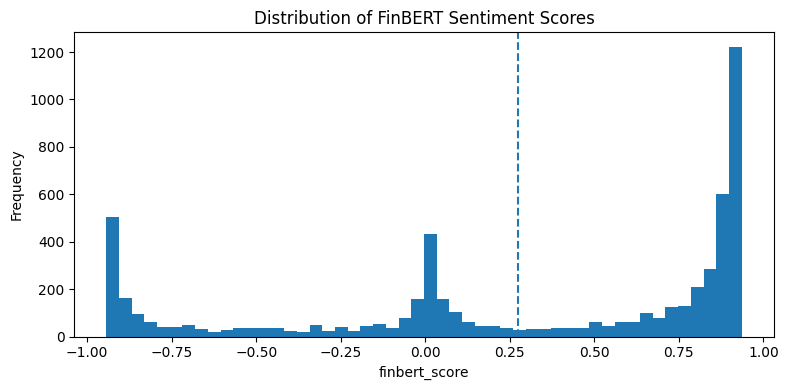

<Figure size 800x400 with 0 Axes>

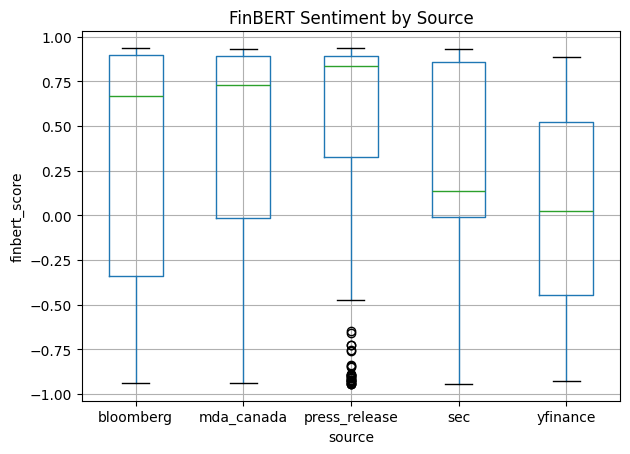

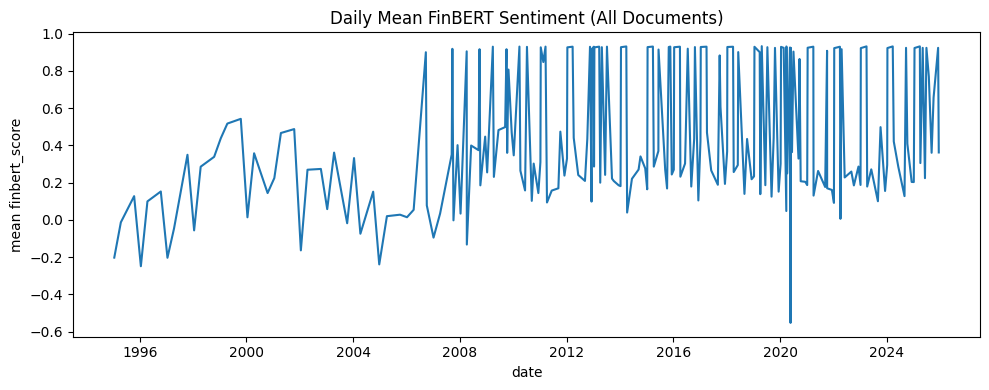

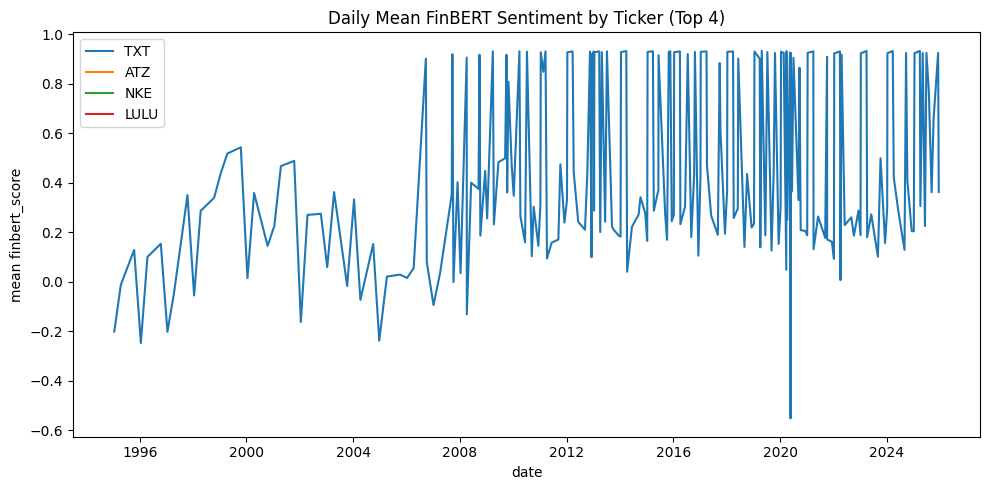

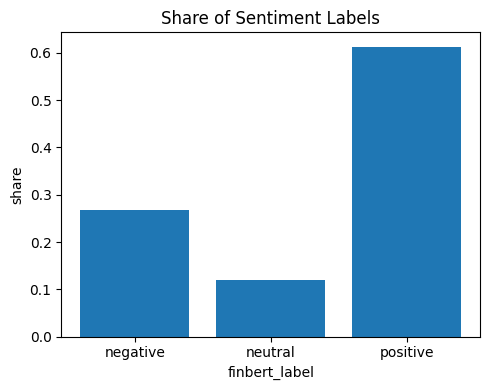

In [15]:
import matplotlib.pyplot as plt

# Ensure date is datetime if you want time-based plots
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

plt.style.use("default")

# 1) Distribution of sentiment scores (histogram)
plt.figure(figsize=(8, 4))
scores = df["finbert_score"].dropna()
plt.hist(scores, bins=50)
plt.axvline(scores.mean(), linestyle="--")
plt.title("Distribution of FinBERT Sentiment Scores")
plt.xlabel("finbert_score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2) Boxplot of sentiment by source (top-k sources)
if "source" in df.columns:
    top_sources = df["source"].value_counts().head(6).index
    df_top_src = df[df["source"].isin(top_sources)]

    plt.figure(figsize=(8, 4))
    df_top_src.boxplot(column="finbert_score", by="source")
    plt.title("FinBERT Sentiment by Source")
    plt.suptitle("")  # remove automatic super title
    plt.xlabel("source")
    plt.ylabel("finbert_score")
    plt.tight_layout()
    plt.show()

# 3) Time-series of mean sentiment over time (overall and per ticker)
if "date" in df.columns:
    # Overall daily mean
    daily_mean = (
        df.dropna(subset=["date"])
        .groupby("date")["finbert_score"]
        .mean()
        .sort_index()
    )

    plt.figure(figsize=(10, 4))
    plt.plot(daily_mean.index, daily_mean.values)
    plt.title("Daily Mean FinBERT Sentiment (All Documents)")
    plt.xlabel("date")
    plt.ylabel("mean finbert_score")
    plt.tight_layout()
    plt.show()

    # Top tickers by count: separate lines
    if "ticker" in df.columns:
        top_tickers = (
            df["ticker"]
            .value_counts()
            .head(4)
            .index
        )
        df_top = df[df["ticker"].isin(top_tickers)].dropna(subset=["date"])

        plt.figure(figsize=(10, 5))
        for t in top_tickers:
            series = (
                df_top[df_top["ticker"] == t]
                .groupby("date")["finbert_score"]
                .mean()
                .sort_index()
            )
            plt.plot(series.index, series.values, label=str(t))
        plt.title("Daily Mean FinBERT Sentiment by Ticker (Top 4)")
        plt.xlabel("date")
        plt.ylabel("mean finbert_score")
        plt.legend()
        plt.tight_layout()
        plt.show()

# 4) Bar chart of label distribution
if "finbert_label" in df.columns:
    label_counts = df["finbert_label"].value_counts(normalize=True).sort_index()
    plt.figure(figsize=(5, 4))
    plt.bar(label_counts.index, label_counts.values)
    plt.title("Share of Sentiment Labels")
    plt.xlabel("finbert_label")
    plt.ylabel("share")
    plt.tight_layout()
    plt.show()
